# Benchmark of methods for brain tumor segmentation 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import nibabel as nib
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skfuzzy.cluster import cmeans
from dipy.segment.mask import median_otsu
from time import time
import glob
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

N_ITERS = 10

# Extracting and preprocessing 

In [2]:
NUMPASS = 5
MEDIAN_RADIUS = 11
HIT = 0.25
BLUR_RADIUS = 3


N_CLUSTERS = 5
N_COMPONENTS = 2

M = 2.0
EPS = 0.01
MAX_IT = 100
    
K1 = np.ones((3, 3), np.uint16)

IMG_ROOT = '/Users/macbook/Documents/Education/4_Year/DiplomaWork/Images/brain/TCIA Low grade glioma/nifti/'

def get_data(root, patients):
    for patient in tqdm(patients, desc='Loading images'):
        img_path = root + 'LGG-%s/LGG-%s_T2.nii.gz' % (patient[0], patient[0])
        seg_path = root + 'LGG-%s/LGG-%s-Segmentation.nii.gz' % (patient[0], patient[0])
        img = nib.load(img_path).get_data()[:, :, patient[1]]
        seg = nib.load(seg_path).get_data()[:, :, patient[1]]
        yield (img, seg)
    
def draw(img, size=(8, 8), cmap='jet'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.plot()
    

# from random import shuffle

# def get_data():
#     NUM = 0
#     for img_path, seg_path in zip(glob.glob(IMG_ROOT + '/**/*T2.nii.gz'), glob.glob(IMG_ROOT + '/**/*Segmentation.nii.gz')):
#         img = nib.load(img_path).get_data()
#         seg = nib.load(seg_path).get_data()
#         s = np.sum(seg.reshape((seg.shape[2], -1)).astype(np.int32), axis=1)
#         indicies = s > 0
#         LEN = indicies.shape[0]
#         NUM += LEN
#         indicies = indicies.reshape((-1))
#         if NUM > LIMIT:
#             raise StopIteration
#         else:
#             print(s)
#             indicies = np.argwhere(indicies).reshape(-1)
#             print(indicies)
#             img2 = img[:, :, indicies]
            
#             seg2 = seg[:, :, indicies]
            
#             print(seg2.shape)
#             print(np.sum(seg2.reshape((seg2.shape[2], -1)).astype(np.int32), axis=1))
#             yield img2[:, :, 4], seg2[:, :, 4]
        

        
def preprocess(data):
    for data_ in tqdm(data, desc='Preprocessing'):
        img = data_[0].astype(np.float32)
        img = cv.medianBlur(img, 3)
        img, _ = median_otsu(img, numpass=NUMPASS, median_radius=MEDIAN_RADIUS)
        original_shape = img.shape
        img = ((img - np.min(img)) / (np.max(img) - np.min(img))).astype(np.float32)
        blurred = cv.blur(img, (19, 19))
        edges = np.clip(img - blurred, 0.0, 1.0)
        edges[edges > HIT] = 1.0
        edges[edges <= HIT] = 0.0
        edges = cv.dilate(edges, np.ones((2, 2)), iterations=1)
        img = np.clip(img - edges, 0.0, 1.0)
        yield (img, data_[1])
    
PATIENTS = [
    ('104', 38),  
    ('220', 25),
    ('225', 35),
    ('229', 14),
    ('249', 35),
    ('374', 45),
    ('600', 25),
    ('500', 33),
    ('547', 39),
    ('311', 39),
    (357, 35),
    (387, 16),
    (345, 30),
    (346, 48),
    (351, 24),
    (354, 28),
    (355, 40),
    (357, 36),
    (359, 33),
    (360, 24),
    (361, 19),
    (363, 23),
    (365, 28),
    (367, 28),
    (371, 35),
    (373, 34),
    (374, 44),
    (375, 43),
    (377, 38),
    (380, 37),
    (383, 38),
    (385, 36),
    (388, 43),
    (391, 25),
    (394, 38),
    (396, 37),
    (492, 40),
    (500, 34),
    (506, 26),
    (515, 25),
    (516, 43),
    (518, 49),
    (519, 23),
    (520, 33),
] 

N = len(PATIENTS)
print(N)

DATA = list(get_data(IMG_ROOT, PATIENTS))
PREP = list(preprocess(DATA))

# INDEX = 0
# orig = DATA[INDEX][0]
# # image = PREP[INDEX][0]
# gt = DATA[INDEX][1]

# # res, labels = multivariate_kmeans(image)
# # print('Dice (%)', calc_dice(res, gt))
# # draw(orig)
# # # draw(labels)
# # # draw(res)
# # draw(gt)

# plt.figure(figsize=(8, 8))
# plt.imshow(orig, 'gray')
# plt.imshow(gt, alpha=0.3)

# plt.plot()

44


# K Means

In [3]:
def kmeans(img, n_clusters):
    img = cv.blur(img, (15, 15))
    x = img.reshape((-1, 1))
    model = KMeans(n_clusters=n_clusters, random_state=0, algorithm='full', precompute_distances=False, n_init=1)
    model.fit(x)
    c_index = np.argmax(model.cluster_centers_.reshape((-1)))
    flat = np.full(img.shape[0] * img.shape[1], 0, dtype=np.uint8)
    flat[model.labels_ == c_index] = 1
    mask = flat.reshape(img.shape)
    mask = cv.dilate(mask, K1, iterations=1)
    mask = cv.erode(mask, K1, iterations=1)
    return mask

# Weighted Multivariate K Means

In [4]:
def multivariate_kmeans(img, n_clusters):
    f1 = cv.blur(img, (7, 7)).reshape((-1, 1))
    f2 = cv.blur(img, (9, 9)).reshape((-1, 1)) 
    f3 = cv.blur(img, (5, 5)).reshape((-1, 1)) 
    f4 = img.reshape((-1, 1)) * 0.45
    xc = np.linspace(0, 1.0, img.shape[1])
    yc = np.linspace(0, 1.0, img.shape[0])
    f5 = np.transpose([np.tile(xc, len(xc)), np.repeat(yc, len(yc))]).reshape((-1, 2)) * 0.015
    f3 = cv.blur(img, (5, 5)).reshape((-1, 1)) 
    X = np.concatenate((f1, f2, f3, f4, f5), axis=1)
    x = X
    model = KMeans(n_clusters=n_clusters, random_state=0, algorithm='full', precompute_distances=False, n_init=1)
    model.fit(x)
    c_index = np.argmax(model.cluster_centers_[:,3])
    flat = np.full(img.shape[0] * img.shape[1], 0, dtype=np.uint8)
    flat[model.labels_ == c_index] = 1
    mask = flat.reshape(img.shape)
    mask = cv.erode(mask, K1, iterations=1)
    mask = cv.dilate(mask, K1, iterations=1)
    return mask

# Fuzzy C Means

In [5]:
def fcm(img, n_clusters):
    M = 2
    img = cv.blur(img, (15, 15))
    flat = img.reshape((1, -1))
    c, u, a1, a2, a3, a4, a5 = cmeans(flat, n_clusters, M, EPS, 50)
    tumor_index = np.argmax(c, axis=0)
    defuz = np.argmax(u, axis=0)
    mask = np.full(defuz.shape[0], 0, dtype=np.uint16)
    mask[defuz == tumor_index] = 1
    mask = mask.reshape(img.shape)
    mask = cv.erode(mask, K1, iterations=1)
    mask = cv.dilate(mask, K1, iterations=1)
    return mask

# Gaussian Mixture

In [6]:
def gaussian_mixture(img, n_components):
    img = cv.blur(img, (15, 15))
    x = img.reshape((-1, 1))
    model = GaussianMixture(n_components=n_components, covariance_type='spherical')
    model.fit(x)
    labels = model.predict(x)
    c_index = np.argmax(model.means_)
    flat = np.full(img.shape[0] * img.shape[1], 0, dtype=np.uint8)
    flat[labels == c_index] = 1
    mask = flat.reshape(img.shape)
    mask = cv.erode(mask, K1, iterations=1)
    mask = cv.dilate(mask, K1, iterations=1)
    return mask

# Binary thresholding

In [7]:
def find_threshold_cpu(img, max_it=100, eps=0.001):
    cols = img.shape[1]

    mid = cols // 2
    p1 = img[:, :mid].reshape((-1))
    p2 = img[:, mid:].reshape((-1))
    img = img.reshape((-1))

    it = -1
    while True:
        t1 = np.mean(p1)
        t2 = np.mean(p2)

        t = (t1 + t2) / 2.0
        it += 1
        if it >= max_it or abs(t1 - t2) <= eps:
            return t
        else:
            p1 = img[img < t]
            p2 = img[img >= t]
        
def threshold(img):
    t = find_threshold_cpu(img, max_it=MAX_IT, eps=EPS)
    mask = (img > t).astype(np.int16)
    mask = cv.erode(mask, K1, iterations=1)
    mask = cv.dilate(mask, K1, iterations=1)
    return mask

In [8]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import cv2 as cv
import numpy as np
from dipy.segment.mask import median_otsu
from pydicom import Dataset

from jinja2 import Template
import numpy as np

BLOCKDIM = 1024

SRC = '''
    #define N {{N}}
    #define BLOCKDIM 1024
    
    struct Cluster{
        float sum;
        int count;
    };
    
    __device__ Cluster clusters_d[(N + BLOCKDIM - 1) / BLOCKDIM];
    
    __device__ float euclidian_dist(const float a, const float b){
        float dist = a - b;
        return hypotf(dist, dist);
    }
    
    __global__ void relabel(const float* src, const float* clusters, int n, int nClusters, int* labels){
        int pos = threadIdx.x + blockIdx.x * blockDim.x;
        if(pos < n){
            float minDist = 1.0f;
            int clusterIndex = 0;
            for(int c = 0; c < nClusters; c++){
                float dist = euclidian_dist(src[pos], clusters[c]);
                if(dist <= minDist){
                    clusterIndex = c;
                    minDist = dist;
                }
            }
            labels[pos] = clusterIndex;
        }
    }
    
    __global__ void calculateClusters(const float* src, const int* labels, int n, int clusterIndex){
        extern __shared__ Cluster _clusters[];
        int pos = threadIdx.x + blockIdx.x * blockDim.x;
        int tid = threadIdx.x;
        _clusters[tid] = Cluster();
        _clusters[tid].sum = 0.0f;
        _clusters[tid].count = 0;
        if(pos < n && labels[pos] == clusterIndex){
            _clusters[tid].sum = src[pos];
            _clusters[tid].count = 1;
        }
        __syncthreads();
        for(unsigned int stride = blockDim.x / 2; stride > 0; stride /= 2){
            if(threadIdx.x < stride){
                _clusters[tid].sum += _clusters[tid + stride].sum;
            }
            __syncthreads();
            if(threadIdx.x < stride){
                _clusters[tid].count += _clusters[tid + stride].count;
            }
            __syncthreads();
        }
        __syncthreads();
        if(threadIdx.x == 0){
            clusters_d[blockIdx.x].sum = _clusters[0].sum;
            clusters_d[blockIdx.x].count = _clusters[0].count;
        }
    }
    
    __global__ void findCenters(int n, int clusterIndex, float* dst){
        extern __shared__ Cluster _clusters[];
        int pos = threadIdx.x + blockIdx.x * blockDim.x;
        int tid = threadIdx.x;
        _clusters[tid] = clusters_d[pos];
        __syncthreads();
        for(unsigned int stride = blockDim.x / 2; stride > 0; stride /= 2){
            if(tid < stride){
                _clusters[tid].sum += _clusters[tid + stride].sum;
            }
            __syncthreads();
            if(tid < stride){
                _clusters[tid].count += _clusters[tid + stride].count;
            }
            __syncthreads();
        }
        __syncthreads();
        if(tid == 0){
            dst[clusterIndex] = _clusters[0].count > 0 ? _clusters[0].sum / (_clusters[0].count * 1.0f) : 0.0f;
        }
    }
'''

def cuda_kmeans(img, n_clusters):
        w = img.shape[1]
        h = img.shape[0]
        n = w * h
        max_it = 30

        img = cv.blur(img, (13, 13))
        src = img.reshape((-1))

        module = SourceModule(Template(SRC).render(N=n))
        relabel = module.get_function('relabel')
        calculate_clusters = module.get_function('calculateClusters')
        find_centers = module.get_function('findCenters')

        t0 = time() * 1000
        centers = np.random.rand(n_clusters).astype(np.float32)

        # Image
        src_gpu = cuda.mem_alloc(src.nbytes)
        cuda.memcpy_htod(src_gpu, src)

        # Cluster centers

        centers_gpu = cuda.mem_alloc(centers.nbytes)
        cuda.memcpy_htod(centers_gpu, centers)

        # Labels
        labels = np.empty_like(src).astype(np.int32)
        labels_gpu = cuda.mem_alloc(labels.nbytes)
        cuda.memcpy_htod(labels_gpu, labels)
        
        start = cuda.Event()
        end = cuda.Event()
        
        t1 = time() * 1000
        
        start.record()
        for it in range(max_it):
            relabel(src_gpu, centers_gpu, np.int32(n), np.int32(n_clusters), labels_gpu,
                    block=(BLOCKDIM, 1, 1), grid=((n + BLOCKDIM - 1) // BLOCKDIM, 1))
            for c in range(n_clusters):
                calculate_clusters(src_gpu, labels_gpu, np.int32(n), np.int32(c),
                                   block=(BLOCKDIM, 1, 1), grid=((n + BLOCKDIM - 1) // BLOCKDIM, 1),
                                   shared=8 * BLOCKDIM)
                find_centers(np.int32(n), np.int32(c), centers_gpu,
                             block=((n + BLOCKDIM - 1) // BLOCKDIM, 1, 1), grid=((1, 1)),
                             shared=8 * (n + BLOCKDIM - 1) // BLOCKDIM)

        
        end.record()
        end.synchronize()
        msecs = end.time_since(start)*1e-3
        msecs *= 1000
        msecs += t1 - t0
        
        t0 = time() * 1000
        cuda.memcpy_dtoh(labels, labels_gpu)
        cuda.memcpy_dtoh(centers, centers_gpu)
#
        labels = labels.reshape((-1))
        c_index = np.argmax(centers)
        flat = np.full(n, 0, dtype=np.uint8)
        flat[labels == c_index] = 1
        mask = flat.reshape((h, w))
        mask = cv.erode(mask, kernel=K1, iterations=1)
        mask = cv.dilate(mask, kernel=K1, iterations=1)
        t1 = time() * 1000
        msecs += t1 - t0
        return mask, msecs

cuda_kmeans.is_cuda = True

# Profile average time and accuracy (Dice-Sørensen) per image

In [9]:
import collections
ALGS = collections.OrderedDict()
ALGS['K Means'] = kmeans
ALGS['Fuzzy C Means'] = fcm
ALGS['Gaussian Mixture'] = gaussian_mixture
ALGS['Multivariate K Means'] = multivariate_kmeans
ALGS['CUDA K Means'] = cuda_kmeans


def t(alpha, gl):
    return scipy.stats.t.ppf(1-(alpha/2), gl)

TP_INDEX = 0
FP_INDEX = 1
FN_INDEX = 2
DC_INDEX = 3
PR_INDEX = 4
RC_INDEX = 5
F1_INDEX = 6

def calc_accuracy(seg, gt):
    size = seg.shape[0] * seg.shape[1]
    tp = np.sum(seg[gt==1])
    tn = np.sum(seg[gt==0])
    
    fp = np.sum((gt==0) & (seg==1))
    fn = np.sum((gt==1) & (seg==0))
    dc = 2.0 * tp / (np.sum(gt) + np.sum(seg)) * 100.0

    precision = tp / (tp + fp) * 100.0 
    recall = tp / (tp + fn) * 100.0

    tp = tp * 100.0 / size
    fp = fp * 100.0 / size
    fn = fn * 100.0 / size
    return dc

def profile(alg, data, n_clusters):
    avg_time = []
    avg_accuracy = []
    for data_item in iter(data):
        time_it = []
        accuracy_it = []
        img, gt = data_item[0], data_item[1]
        for i in range(N_ITERS):
            duration = 0.0
            if getattr(alg, 'is_cuda', False):
                seg, duration = alg(img, n_clusters)
            else:
                t0 = time()
                seg = alg(img, n_clusters)
                t1 = time()
                duration = (t1 - t0) * 1000.0
            
            time_it.append([duration])
            accuracy_it.append(calc_accuracy(seg, gt))
        avg_time.append(np.mean(time_it))
        avg_accuracy.append(np.mean(accuracy_it))
    return avg_time, avg_accuracy

In [10]:
N_CLUSTERS_RANGE = (3, 10)
t_avg_accuracy = []
conf95_accuracy = []

t_avg_time = []
conf95_time = []

CONF_INT_COEFF = 1.0 / sqrt(N) * t(0.05, N - 1)

avg_time_per_n_clusters = []
avg_acc_per_n_clusters = []

for N_CLUSTERS in tqdm(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1]), desc='Collecting data'):
    print('================================')
    print('N CLUSTERS = ', N_CLUSTERS)
    print('================================')
    time_t, accuracy_t = {}, {}
    for alg in tqdm(ALGS.keys()):
        avg_time, avg_accuracy = profile(ALGS[alg], PREP, N_CLUSTERS)
        time_t[alg] = avg_time
        accuracy_t[alg] = avg_accuracy

    print('Average time per image')
    print(time_t)
    print('\n')

    print('Average accuracy per image')
    print(accuracy_t)
    print('\n')

    
    t_avg_time_alg = []
    t_avg_accuracy_alg = []
    conf95_time_alg = []
    conf95_accuracy_alg = []
    
    avg_time_per_alg = []
    for alg, time_per_image in tqdm(time_t.items(), desc='Avg time per algorithm (N_CLUSTERS = %d)' % N_CLUSTERS):
        avg_time_per_alg.append(time_per_image)
        t_avg_time_ = np.mean(time_per_image)
        t_std_time_ = np.std(time_per_image)
        t_avg_time_alg.append(t_avg_time_)
#         t_std_time[i].append(t_std_time_)
        conf95_time_alg.append(
            [
                t_avg_time_ - t_std_time_ * CONF_INT_COEFF, 
                t_avg_time_ + t_std_time_ * CONF_INT_COEFF
            ]
        )
    avg_time_per_n_clusters.append(avg_time_per_alg)

    avg_acc_per_alg = []
    for alg, accuracy_per_image in tqdm(accuracy_t.items(), desc='Avg acc per algorithm (N_CLUSTERS = %d)' % N_CLUSTERS):
        avg_acc_per_alg.append(accuracy_per_image)
        t_avg_accuracy_ = np.mean(accuracy_per_image)
        t_std_accuracy_ = np.std(accuracy_per_image)
        t_avg_accuracy_alg.append(t_avg_accuracy_)
#         t_std_accuracy[i].append(t_std_accuracy_)
        conf95_accuracy_alg.append(
            [
                t_avg_accuracy_ - t_std_accuracy_ * CONF_INT_COEFF, 
                t_avg_accuracy_ + t_std_accuracy_ * CONF_INT_COEFF
            ]
        )
    avg_acc_per_n_clusters.append(avg_time_per_alg)
    
    t_avg_time.append(t_avg_time_alg)
    t_avg_accuracy.append(t_avg_accuracy_alg)
    conf95_time.append(conf95_time_alg)
    conf95_accuracy.append(conf95_accuracy_alg)

print('Total average time (msecs)')
print(t_avg_time)
print('\n')

# print('Total std of time (msecs)^2')
# print(t_std_time)
# print('\n')

print('95% Confidence interval of time (msecs)')
print(conf95_time)
print('\n')

print('Total average accuracy (%)')
print(t_avg_accuracy)
print('\n')

#     print('Total std of accuracy (%)')
#     print(t_std_accuracy)
#     print('\n')

print('95% Confidence interval of accuracy (%)')
print(conf95_accuracy)
print('\n')

N CLUSTERS =  3


Average time per image
{'K Means': [22.809720039367676, 39.04249668121338, 93.50452423095703, 15.908503532409668, 22.429227828979492, 24.319887161254883, 21.720552444458008, 29.192161560058594, 47.0761775970459, 29.413723945617676, 18.29519271850586, 149.8673677444458, 17.72933006286621, 16.348862648010254, 20.934271812438965, 17.36934185028076, 20.59330940246582, 15.053105354309082, 35.126566886901855, 33.534908294677734, 85.02278327941895, 17.58143901824951, 21.593952178955078, 18.102169036865234, 22.966337203979492, 22.438430786132812, 22.04756736755371, 14.296340942382812, 20.47276496887207, 15.160655975341797, 18.444132804870605, 23.294782638549805, 46.57912254333496, 17.580485343933105, 22.722959518432617, 18.452882766723633, 48.16722869873047, 45.655107498168945, 17.50197410583496, 73.5776424407959, 31.214046478271484, 65.6585693359375, 33.07981491088867, 19.642281532287598], 'Fuzzy C Means': [467.87333488464355, 841.1651372909546, 782.8685998916626, 458.96453857421875, 638.7812

N CLUSTERS =  4


Average time per image
{'K Means': [29.737401008605957, 47.27070331573486, 39.73133563995361, 20.329713821411133, 27.826571464538574, 57.479095458984375, 91.75193309783936, 39.01238441467285, 26.55808925628662, 28.01225185394287, 28.007793426513672, 108.3655595779419, 28.484630584716797, 26.19161605834961, 29.279232025146484, 39.261674880981445, 35.66615581512451, 32.16907978057861, 53.50017547607422, 61.85493469238281, 79.31880950927734, 33.41634273529053, 70.04356384277344, 28.482961654663086, 25.988388061523438, 195.7564353942871, 91.68615341186523, 41.66920185089111, 31.188631057739258, 27.48563289642334, 55.86650371551514, 67.80290603637695, 33.42740535736084, 67.63005256652832, 58.30545425415039, 40.22321701049805, 32.90657997131348, 28.72488498687744, 27.34501361846924, 122.71265983581543, 55.20803928375244, 25.08111000061035, 35.120606422424316, 21.84896469116211], 'Fuzzy C Means': [900.8481502532959, 1159.4550132751465, 1181.571626663208, 680.2586317062378, 928.3991098403931, 

N CLUSTERS =  5


Average time per image
{'K Means': [63.93430233001709, 37.68808841705322, 56.253862380981445, 30.621886253356934, 37.931203842163086, 33.77695083618164, 103.41510772705078, 66.15443229675293, 47.853851318359375, 30.904436111450195, 40.54398536682129, 239.93496894836426, 48.052120208740234, 41.47536754608154, 33.89713764190674, 48.105812072753906, 64.52202796936035, 33.595967292785645, 34.96987819671631, 38.39418888092041, 107.82721042633057, 60.60209274291992, 56.096768379211426, 26.49397850036621, 40.82174301147461, 69.78967189788818, 37.26623058319092, 67.34127998352051, 41.85628890991211, 48.94912242889404, 30.394363403320312, 27.268362045288086, 71.12698554992676, 41.709280014038086, 26.402592658996582, 207.43842124938965, 49.73194599151611, 73.91271591186523, 89.12360668182373, 143.5333490371704, 70.21012306213379, 68.15469264984131, 40.4510498046875, 35.30583381652832], 'Fuzzy C Means': [1390.0197982788086, 1465.5629634857178, 1466.3710355758667, 1445.5952167510986, 1459.82296466

N CLUSTERS =  6


Average time per image
{'K Means': [64.727783203125, 59.488749504089355, 94.05093193054199, 50.97150802612305, 45.74782848358154, 71.95689678192139, 134.10298824310303, 86.99877262115479, 39.719247817993164, 67.65408515930176, 67.56737232208252, 232.95843601226807, 100.40488243103027, 86.572265625, 149.631667137146, 88.48044872283936, 76.77412033081055, 41.111207008361816, 45.54638862609863, 46.00389003753662, 55.51102161407471, 55.069732666015625, 122.67963886260986, 49.62902069091797, 50.24373531341553, 46.54374122619629, 128.96840572357178, 77.66551971435547, 49.33576583862305, 90.33536911010742, 42.67559051513672, 41.61694049835205, 140.58539867401123, 71.73376083374023, 72.09441661834717, 83.6524248123169, 72.19226360321045, 94.2695140838623, 98.04873466491699, 252.4160861968994, 87.06493377685547, 102.00920104980469, 56.81893825531006, 137.4666690826416], 'Fuzzy C Means': [1784.2230319976807, 1778.522229194641, 1773.832893371582, 1771.497106552124, 1799.3708848953247, 1771.680808

N CLUSTERS =  7


Average time per image
{'K Means': [95.58584690093994, 112.95897960662842, 138.4021282196045, 80.32889366149902, 45.78258991241455, 50.50389766693115, 88.0756139755249, 40.07706642150879, 127.53157615661621, 49.979329109191895, 69.74351406097412, 274.3532180786133, 99.09298419952393, 103.38354110717773, 65.0651216506958, 49.443602561950684, 74.72116947174072, 185.63416004180908, 144.1734790802002, 128.78966331481934, 45.35236358642578, 50.97236633300781, 131.54432773590088, 127.16410160064697, 83.8752031326294, 165.29581546783447, 73.99401664733887, 68.70758533477783, 157.10322856903076, 40.798282623291016, 59.93540287017822, 78.02906036376953, 40.12486934661865, 71.3062047958374, 119.0166711807251, 45.95959186553955, 87.3948335647583, 55.51934242248535, 54.60848808288574, 272.55351543426514, 116.07246398925781, 101.98416709899902, 60.50989627838135, 182.7646017074585], 'Fuzzy C Means': [2139.02428150177, 2130.5381298065186, 2125.693678855896, 2119.7726726531982, 2134.3936920166016, 21

N CLUSTERS =  8


Average time per image
{'K Means': [81.67533874511719, 69.29256916046143, 69.27039623260498, 52.81188488006592, 237.37761974334717, 132.12730884552002, 190.29603004455566, 74.85930919647217, 107.06095695495605, 79.85198497772217, 101.29067897796631, 774.3083477020264, 69.48199272155762, 253.03516387939453, 77.10661888122559, 140.14084339141846, 83.61279964447021, 67.8518295288086, 88.3927583694458, 67.7785873413086, 71.8604564666748, 82.29870796203613, 125.32730102539062, 104.78148460388184, 193.02518367767334, 72.07858562469482, 57.02948570251465, 55.85982799530029, 47.066450119018555, 61.666202545166016, 72.20184803009033, 87.66546249389648, 115.12787342071533, 50.90279579162598, 55.93099594116211, 242.5253391265869, 67.18144416809082, 67.03689098358154, 99.96399879455566, 707.5436115264893, 142.57771968841553, 282.17740058898926, 100.42638778686523, 72.14653491973877], 'Fuzzy C Means': [2411.041498184204, 2409.326457977295, 2407.01425075531, 2404.347038269043, 2404.8255443573, 2400.

N CLUSTERS =  9


Average time per image
{'K Means': [78.93884181976318, 62.116026878356934, 81.84247016906738, 158.13920497894287, 69.91713047027588, 69.41518783569336, 311.46233081817627, 287.4699115753174, 76.44174098968506, 98.76794815063477, 115.29960632324219, 458.20531845092773, 99.40674304962158, 105.53953647613525, 75.76272487640381, 82.15813636779785, 64.40799236297607, 105.8408260345459, 99.65908527374268, 86.34600639343262, 63.97757530212402, 123.37913513183594, 75.74975490570068, 87.50040531158447, 74.66139793395996, 158.2284450531006, 76.8099308013916, 122.24359512329102, 170.87373733520508, 75.01847743988037, 97.94974327087402, 69.7512149810791, 69.77462768554688, 81.80711269378662, 128.307843208313, 104.31828498840332, 211.02354526519775, 57.531142234802246, 153.5942792892456, 319.65224742889404, 145.1955795288086, 80.21054267883301, 93.3152437210083, 75.19395351409912], 'Fuzzy C Means': [2754.8120498657227, 2741.6464805603027, 2748.836398124695, 2744.6404933929443, 2837.3046159744263, 2


Total average time (msecs)
[[32.534606890244916, 672.4392278627915, 253.98795008659363, 67.82175139947371, 21.132452108643275], [48.81204204125838, 1214.112156087702, 273.0829363519495, 99.01420690796591, 25.193494137850674], [60.54166555404663, 1646.818649226969, 326.99888890439814, 171.88579765233126, 30.775412368774415], [84.7521884874864, 2100.9030992334538, 363.8942566784945, 184.540963714773, 35.783446363969276], [98.05029034614563, 2505.9311189434743, 427.28867205706507, 273.93574931404805, 41.19599258249457], [133.00056836821815, 2878.682829575105, 489.6806689825925, 365.63262722708964, 46.52273746837269], [120.5273769118569, 3215.058025446805, 509.63903123682195, 1189.0057336200368, 52.00541328950362]]


95% Confidence interval of time (msecs)
[[[24.7424563527671, 40.32675742772273], [555.0129469609893, 789.8655087645938], [209.20187139139523, 298.774028781792], [51.34120945516422, 84.3022933437832], [17.90783664070532, 24.35706757658123]], [[38.90467200617964, 58.71941207633

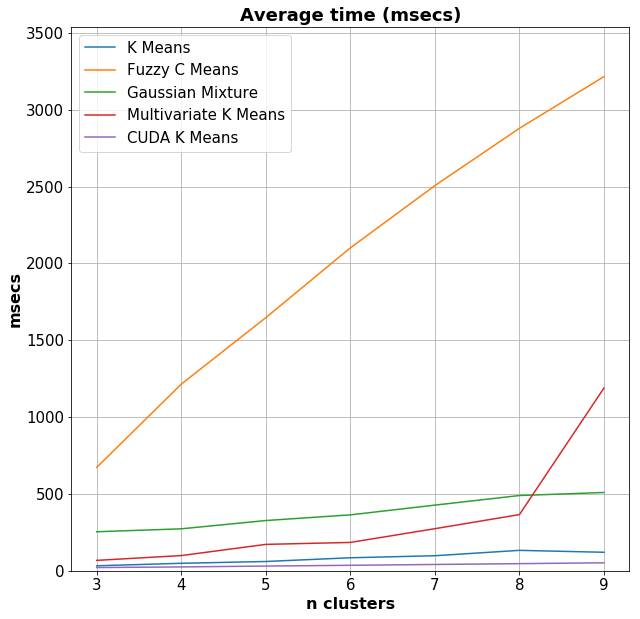

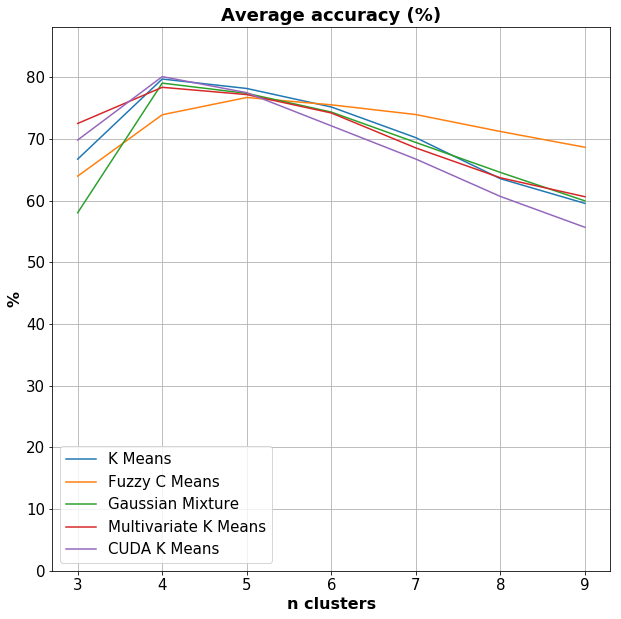

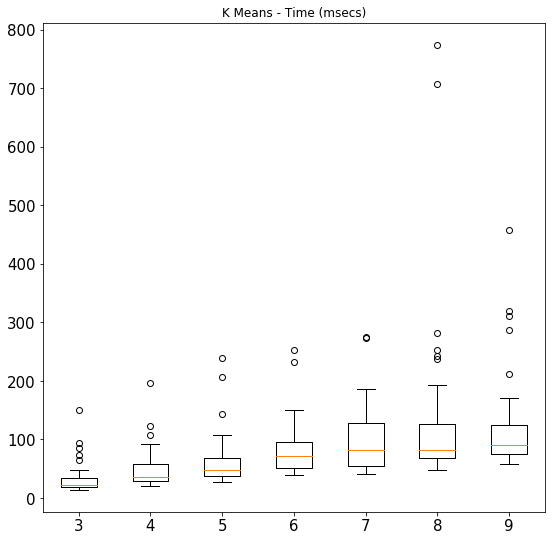

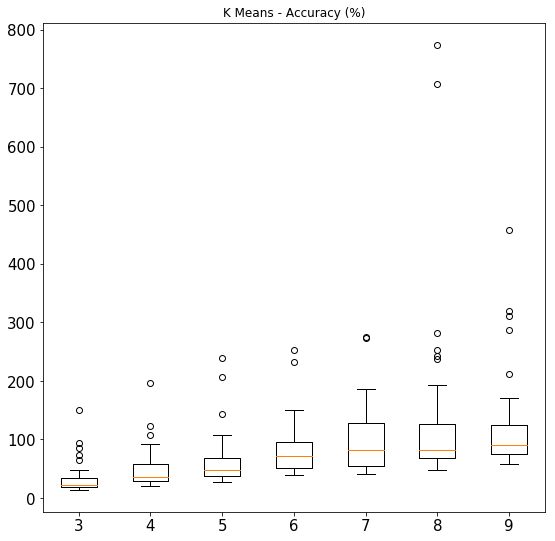

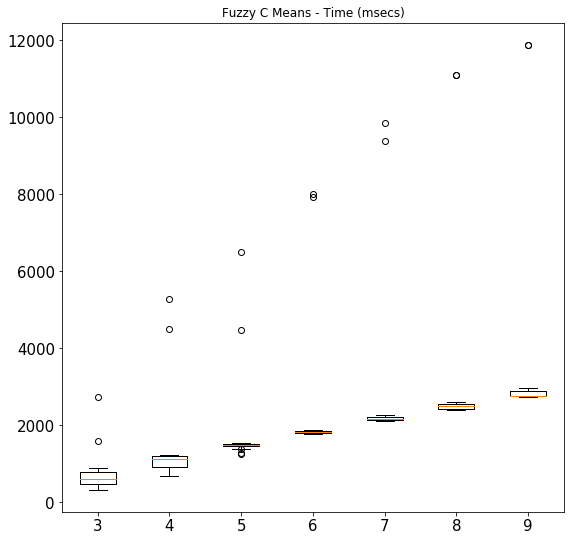

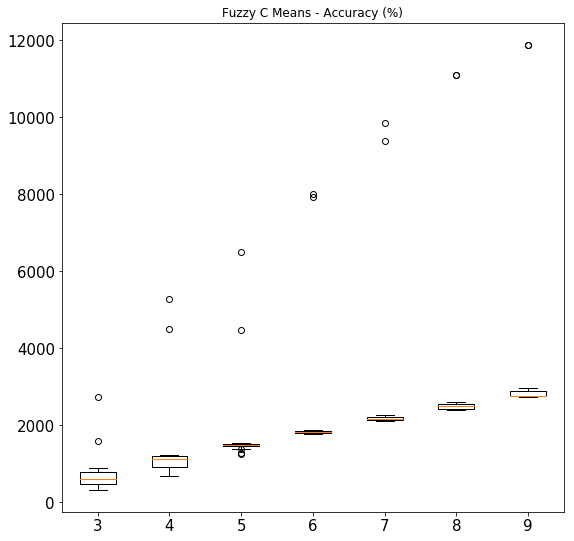

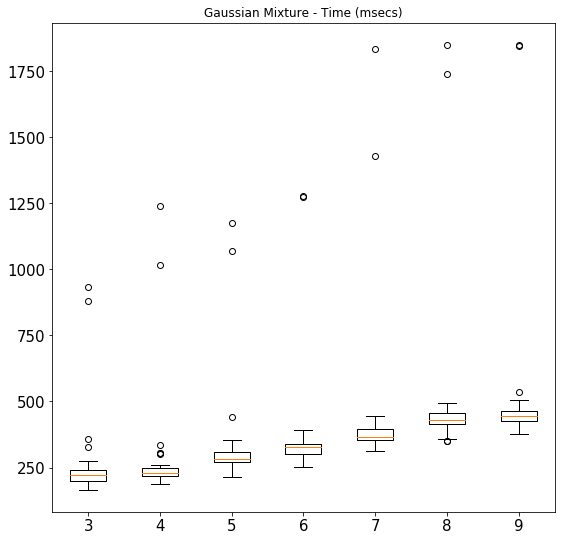

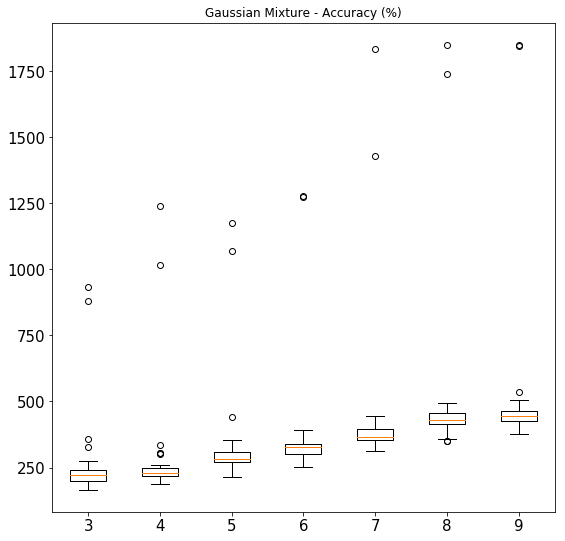

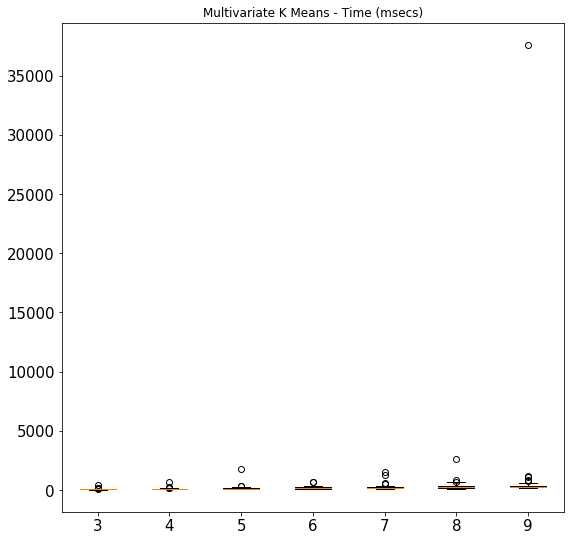

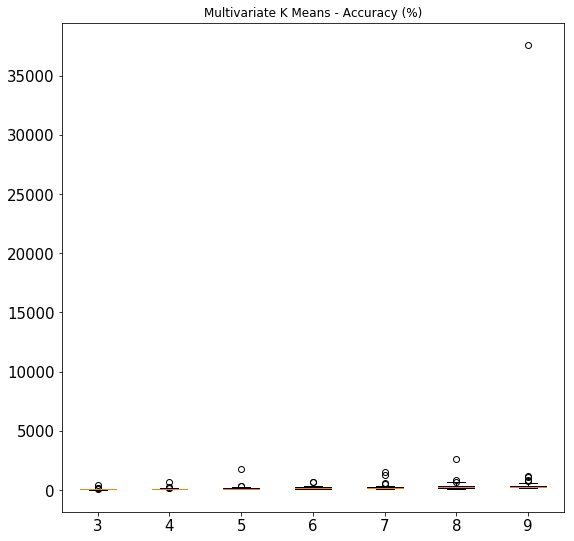

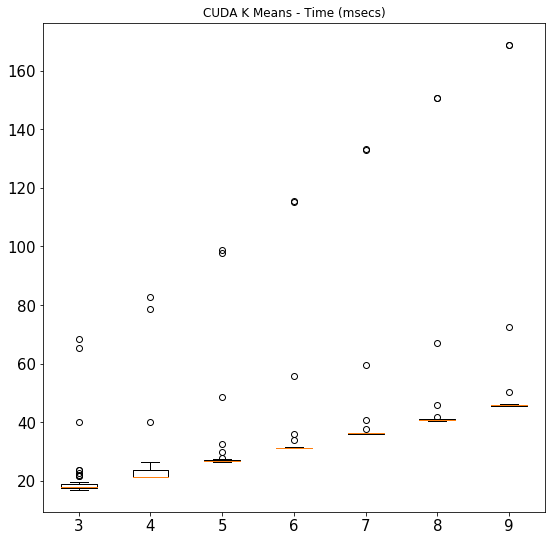

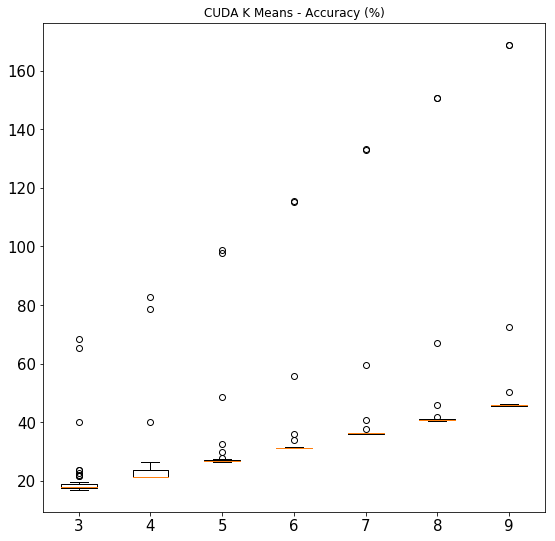



-----> K Means <-----


[Average time]
[ 32.53460689  48.81204204  60.54166555  84.75218849  98.05029035
 133.00056837 120.52737691]


[Average accuracy]
[66.71818937 79.70465936 78.16947927 75.16909958 70.19522561 63.54637998
 59.54883472]


[Conf 95% time]
[[ 24.74245635  40.32675743]
 [ 38.90467201  58.71941208]
 [ 47.51193029  73.57140082]
 [ 70.98071446  98.52366252]
 [ 81.35957227 114.74100843]
 [ 89.00306165 176.99807509]
 [ 96.06288648 144.99186734]]


[Conf 95% accuracy]
[[57.25880521 76.17757354]
 [74.75980273 84.64951599]
 [73.71314982 82.62580872]
 [70.70933584 79.62886332]
 [65.95420257 74.43624866]
 [58.89921128 68.19354867]
 [55.14451786 63.95315159]]


-----> Fuzzy C Means <-----


[Average time]
[ 672.43922786 1214.11215609 1646.81864923 2100.90309923 2505.93111894
 2878.68282958 3215.05802545]


[Average accuracy]
[63.96286271 73.91196166 76.7092042  75.52268187 73.94477535 71.2003409
 68.64566947]


[Conf 95% time]
[[ 555.01294696  789.86550876]
 [ 965.10204842 146

In [102]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
rcParams['legend.fontsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

res_time = np.asarray(t_avg_time)
res_acc = np.asarray(t_avg_accuracy)
conf95_time_res = np.asarray(conf95_time)
conf95_acc_res = np.asarray(conf95_accuracy)

avg_time_per_n_clusters = np.asarray(avg_time_per_n_clusters)
avg_acc_per_n_clusters = np.asarray(avg_acc_per_n_clusters)

X = np.arange(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])
plt.title('Average time (msecs)', fontsize=18, fontweight='bold')
plt.xticks(X)
plt.xlabel('n clusters', fontweight="bold", fontsize=16)
plt.ylabel('msecs', fontweight="bold", fontsize=16)
plt.ylim(0, np.max(res_time) * 1.1)
# plt.yscale('log', basey=10)
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    # ax.set_xticklabels(['K=%d' % k for k in range(3, 6)])
    plt.plot(X, res_time[:,i], label=alg)
#     plt.fill_between(X, conf95_time_res[:,i,0], conf95_time_res[:,i,1], alpha=0.15)
    # plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


plt.title('Average accuracy (%)', fontsize=18, fontweight='bold')
plt.xticks(X)
plt.xlabel('n clusters', fontweight="bold", fontsize=16)
plt.ylabel('%', fontweight="bold", fontsize=16)
plt.ylim(0, np.max(res_acc) * 1.1)
# plt.yscale('log', basey=10)
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    # ax.set_xticklabels(['K=%d' % k for k in range(3, 6)])
    plt.plot(X, res_acc[:,i], label=alg)
#     plt.fill_between(X, conf95_acc_res[:,i,0], conf95_acc_res[:,i,1], alpha=0.15)
    # plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

import matplotlib
palegreen = matplotlib.colors.colorConverter.to_rgb('#8CFF6F')
paleblue = matplotlib.colors.colorConverter.to_rgb('#708DFF')
    
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    fig = plt.figure(1, figsize=(9, 9))
    ax = fig.add_subplot(111)
    
    ax.set_title('%s - Time (msecs)' % alg)
    bp = ax.boxplot(avg_time_per_n_clusters[:,i,:].T)
    ax.set_xticklabels(list(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])))
    plt.show()

    fig = plt.figure(1, figsize=(9, 9))
    ax = fig.add_subplot(111)
    
    ax.set_title('%s - Accuracy (%%)' % alg)
    bp = ax.boxplot(avg_acc_per_n_clusters[:,i,:].T)
    ax.set_xticklabels(list(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])))
    plt.show()

for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    print("\n")
    print("===========================")
    print('----->', alg, '<-----')
    print("\n")
    print('[Average time]')
    print(res_time[:,i])
    print("\n")
    print('[Average accuracy]')
    print(res_acc[:,i])
    print("\n")
    print('[Conf 95% time]')
    print(conf95_time_res[:,i,:])
    print("\n")
    print('[Conf 95% accuracy]')
    print(conf95_acc_res[:,i,:])


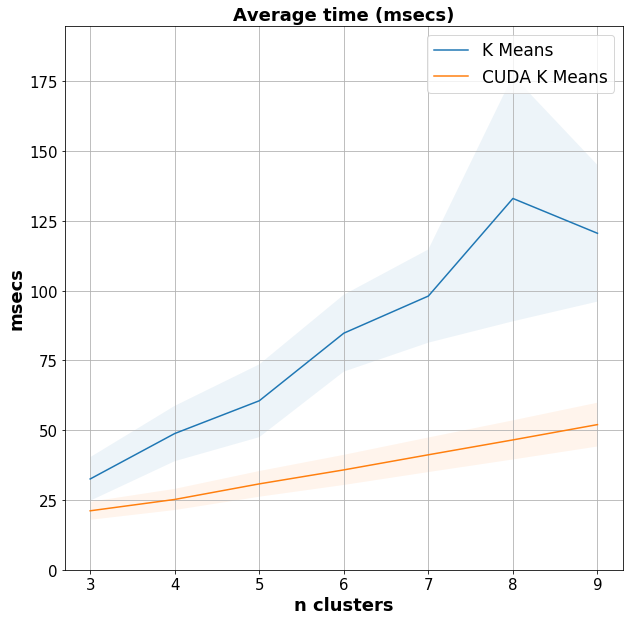

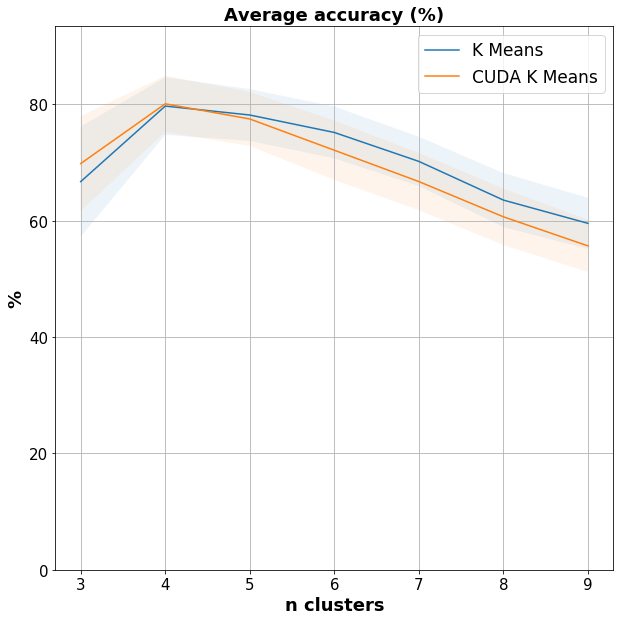

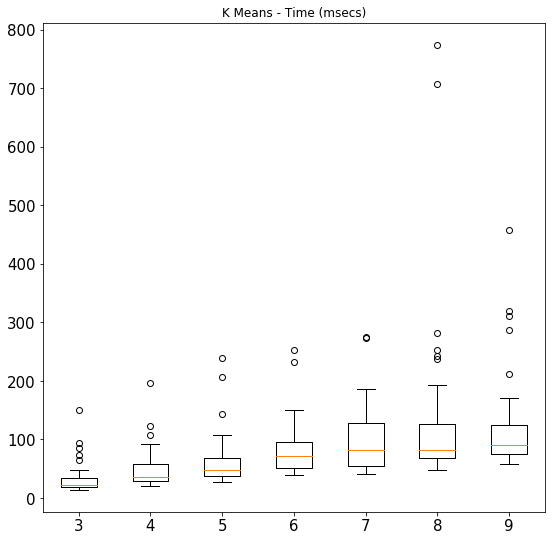

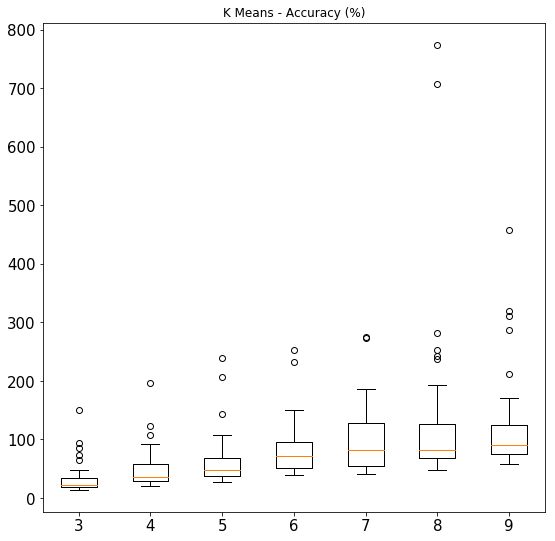

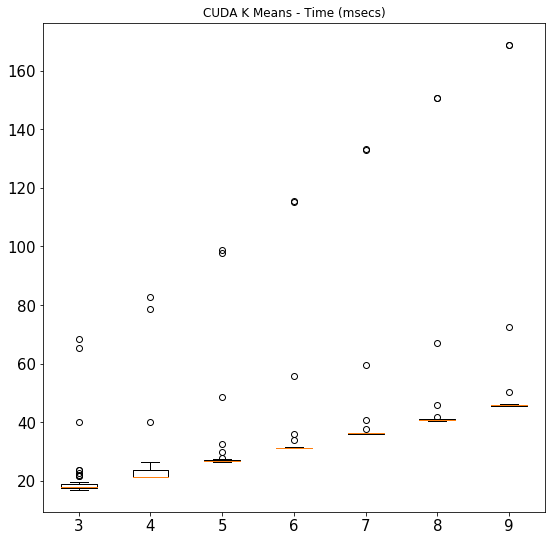

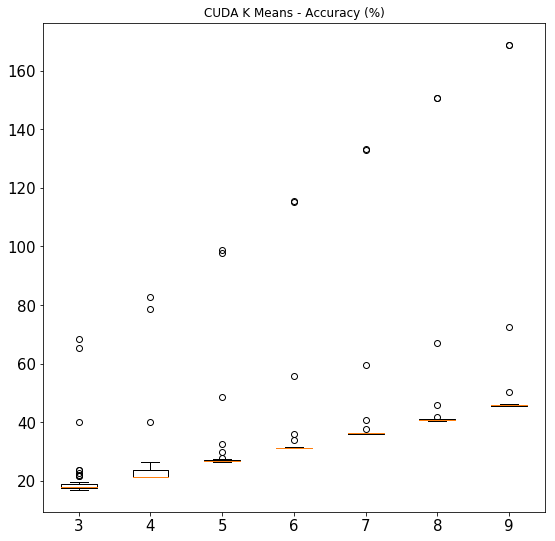



-----> K Means <-----


[Average time]
[ 32.53460689  48.81204204  60.54166555  84.75218849  98.05029035
 133.00056837 120.52737691]


[Average accuracy]
[66.71818937 79.70465936 78.16947927 75.16909958 70.19522561 63.54637998
 59.54883472]


[Conf 95% time]
[[ 24.74245635  40.32675743]
 [ 38.90467201  58.71941208]
 [ 47.51193029  73.57140082]
 [ 70.98071446  98.52366252]
 [ 81.35957227 114.74100843]
 [ 89.00306165 176.99807509]
 [ 96.06288648 144.99186734]]


[Conf 95% accuracy]
[[57.25880521 76.17757354]
 [74.75980273 84.64951599]
 [73.71314982 82.62580872]
 [70.70933584 79.62886332]
 [65.95420257 74.43624866]
 [58.89921128 68.19354867]
 [55.14451786 63.95315159]]


-----> CUDA K Means <-----


[Average time]
[21.13245211 25.19349414 30.77541237 35.78344636 41.19599258 46.52273747
 52.00541329]


[Average accuracy]
[69.82104879 80.09259714 77.48809021 72.11297495 66.72848282 60.6719585
 55.67041754]


[Conf 95% time]
[[17.90783664 24.35706758]
 [21.40347146 28.98351682]
 [26.176674

In [98]:
from pylab import rcParams
# rcParams['title.fontsize'] = 18
# rcParams['title.fontname'] = "Times New Roman Bold"
rcParams['figure.figsize'] = 10, 10
rcParams['legend.fontsize'] = 17
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

res_time = np.asarray(t_avg_time)
res_acc = np.asarray(t_avg_accuracy)
conf95_time_res = np.asarray(conf95_time)
conf95_acc_res = np.asarray(conf95_accuracy)

avg_time_per_n_clusters = np.asarray(avg_time_per_n_clusters)
avg_acc_per_n_clusters = np.asarray(avg_acc_per_n_clusters)

X = np.arange(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])
plt.title('Average time (msecs)', fontsize=18, fontweight="bold")
plt.xticks(X)
plt.xlabel('n clusters', fontsize=18, fontweight="bold")
plt.ylabel('msecs', fontsize=18, fontweight="bold")
plt.ylim(0, np.max(conf95_time_res[:, [0, 4], 1]) * 1.1)
# plt.yscale('log', basey=10)
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    # ax.set_xticklabels(['K=%d' % k for k in range(3, 6)])
    if i == 0 or i == 4:
        plt.plot(X, res_time[:,i], label=alg)
        plt.fill_between(X, conf95_time_res[:,i,0], conf95_time_res[:,i,1], alpha=0.08)
    # plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


plt.title('Average accuracy (%)', fontsize=18, fontname="Times New Roman Bold", fontweight="bold")
plt.xticks(X)
plt.xlabel('n clusters', fontsize=18, fontweight="bold")
plt.ylabel('%', fontsize=18, fontweight="bold")
plt.ylim(0, np.max(conf95_acc_res[:, [0, 4], 1]) * 1.1)
# plt.yscale('log', basey=10)
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    if i == 0 or i == 4:
    # ax.set_xticklabels(['K=%d' % k for k in range(3, 6)])
        plt.plot(X, res_acc[:,i], label=alg)
        plt.fill_between(X, conf95_acc_res[:,i,0], conf95_acc_res[:,i,1], alpha=0.08)
    # plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

import matplotlib
palegreen = matplotlib.colors.colorConverter.to_rgb('#8CFF6F')
paleblue = matplotlib.colors.colorConverter.to_rgb('#708DFF')
    
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    if i == 0 or i == 4:
        fig = plt.figure(1, figsize=(9, 9))
        ax = fig.add_subplot(111)

        ax.set_title('%s - Time (msecs)' % alg)
        bp = ax.boxplot(avg_time_per_n_clusters[:,i,:].T)
        ax.set_xticklabels(list(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])))
        plt.show()

        fig = plt.figure(1, figsize=(9, 9))
        ax = fig.add_subplot(111)

        ax.set_title('%s - Accuracy (%%)' % alg)
        bp = ax.boxplot(avg_acc_per_n_clusters[:,i,:].T)
        ax.set_xticklabels(list(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])))
        plt.show()

for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    if i == 0 or i == 4:
        print("\n")
        print("===========================")
        print('----->', alg, '<-----')
        print("\n")
        print('[Average time]')
        print(res_time[:,i])
        print("\n")
        print('[Average accuracy]')
        print(res_acc[:,i])
        print("\n")
        print('[Conf 95% time]')
        print(conf95_time_res[:,i,:])
        print("\n")
        print('[Conf 95% accuracy]')
        print(conf95_acc_res[:,i,:])


In [80]:
import pandas as pd
df_time = pd.DataFrame(np.round(res_time.T, decimals=2), columns=[str(k) for k in range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])])
df_time.index = ALGS.keys()
df_acc = pd.DataFrame(np.round(res_acc.T, decimals=2), columns=[str(k) for k in range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])])
df_acc.index = ALGS.keys()

conf95_time_res[conf95_time_res < 0] = 0
conf95_acc_res[conf95_acc_res < 0] = 0

# Conf 95 time
df_conf_time = np.apply_along_axis(
    lambda x: '[%.2f, %.2f]' % (x[0], x[1]), 
    2, 
    np.round(conf95_time_res, decimals=2)
).T
df_conf_time = pd.DataFrame(df_conf_time, columns=[str(k) for k in range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])])
df_conf_time.index = ALGS.keys()

# Conf 95 accuracy
df_conf_acc = np.apply_along_axis(
    lambda x: '[%.2f, %.2f]' % (x[0], x[1]), 
    2, 
    np.round(conf95_acc_res, decimals=2)
).T
df_conf_acc = pd.DataFrame(df_conf_acc, columns=[str(k) for k in range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])])
df_conf_acc.index = ALGS.keys()

print('Time\n')
print(df_time)
print('\n')

print('Accuracy\n')
print(df_acc)
print('\n')

print('Time (95% confidence interval)\n')
print(df_conf_time)
print('\n')

print('Accuracy (95% confidence interval)\n')
print(df_conf_acc)

writer = pd.ExcelWriter('benchmark.xlsx')
df_time.to_excel(writer, 'Time')
df_acc.to_excel(writer, 'Accuracy')
df_conf_time.to_excel(writer, 'Time - 95')
df_conf_acc.to_excel(writer, 'Accuracy - 95')
writer.save()

Time

                           3        4        5        6        7        8  \
K Means                32.53    48.81    60.54    84.75    98.05   133.00   
Fuzzy C Means         672.44  1214.11  1646.82  2100.90  2505.93  2878.68   
Gaussian Mixture      253.99   273.08   327.00   363.89   427.29   489.68   
Multivariate K Means   67.82    99.01   171.89   184.54   273.94   365.63   
CUDA K Means           21.13    25.19    30.78    35.78    41.20    46.52   

                            9  
K Means                120.53  
Fuzzy C Means         3215.06  
Gaussian Mixture       509.64  
Multivariate K Means  1189.01  
CUDA K Means            52.01  


Accuracy

                          3      4      5      6      7      8      9
K Means               66.72  79.70  78.17  75.17  70.20  63.55  59.55
Fuzzy C Means         63.96  73.91  76.71  75.52  73.94  71.20  68.65
Gaussian Mixture      58.03  79.04  77.38  74.35  69.42  64.56  59.95
Multivariate K Means  72.50  78.36  77.18  74.2

In [95]:
rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'k',
          'axes.facecolor': 'w',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.